In [2]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.0 MB 8.9 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/3.0 MB 8.4 MB/s eta 0:00:01
     ---------- ----------------------------- 0.8/3.0 MB 7.5 MB/s eta 0:00:01
     ------------- -------------------------- 1.0/3.0 MB 6.4 MB/s eta 0:00:01
     -------------- ------------------------- 1.1/3.0 MB 5.3 MB/s eta 0:00:01
     --------------- ------------------------ 1.1/3.0 MB 4.8 MB/s eta 0:00:01
     --------------- ------------------------ 1.1/3.0 MB 4.8 MB/s eta 0:00:01
     --------------- ------------------------ 1.1/3.0 MB 4.8 MB/s eta 0:00:01
     ---------------- ----------------------- 1.3/3.0 MB 3.3 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/3.0 MB 3.0 MB/s eta 0:00:01
     ------------------ --------------------- 1.4/3.0 MB 3.0 MB/s eta 0:00:01
     ------------------- -------------------- 1.5/3.0 MB 2.8 MB/s eta 0

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


In [4]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.hidden_size = hidden_size
        # Weight matrices
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden
        self.Why = np.random.randn(output_size, hidden_size) * 0.01  # Hidden to output
        # Biases
        self.bh = np.zeros((hidden_size, 1))  # Hidden bias
        self.by = np.zeros((output_size, 1))  # Output bias

    def forward(self, inputs):
        # Forward pass through RNN
        h = np.zeros((self.hidden_size, 1))
        self.hs = [h]  # Store hidden states
        for x in inputs:
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            self.hs.append(h)
        y = np.dot(self.Why, h) + self.by
        return y, h

    def train(self, inputs, targets, learning_rate=0.01):
        # Simple backpropagation through time (BPTT)
        h = np.zeros((self.hidden_size, 1))
        self.hs = [h]
        # Forward pass
        for x in inputs:
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            self.hs.append(h)
        y = np.dot(self.Why, h) + self.by
        # Backward pass
        dy = y - targets  # Shape: (1, 1)
        dWhy = np.dot(dy, h.T)  # Shape: (1, hidden_size)
        dby = dy  # Shape: (1, 1)
        dh = np.dot(self.Why.T, dy)  # Shape: (hidden_size, 1)
        dWxh, dWhh, dbh = 0, 0, 0
        for t in range(len(inputs) - 1, -1, -1):
            dtanh = (1 - self.hs[t + 1] ** 2) * dh  # Shape: (hidden_size, 1)
            dbh += dtanh  # Shape: (hidden_size, 1)
            dWxh += np.dot(dtanh, inputs[t].T)  # Shape: (hidden_size, 1)
            if t > 0:
                dWhh += np.dot(dtanh, self.hs[t].T)  # Shape: (hidden_size, hidden_size)
            dh = np.dot(self.Whh.T, dtanh)  # Shape: (hidden_size, 1)
        # Update weights
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby
        return y


In [5]:
# Data handling functions
def get_stock_data():
    stock_symbol = 'GOOGL'
    start_date = '2015-01-01'
    end_date = '2023-12-31'
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    return df

def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [6]:
# Parameters
SEQ_LENGTH = 20
HIDDEN_SIZE = 10
TRAIN_SIZE = 0.8
EPOCHS = 50

# Get and prepare data
df = get_stock_data()
scaled_data, scaler = preprocess_data(df)

# Split data
train_size = int(len(scaled_data) * TRAIN_SIZE)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Initialize RNN
rnn = SimpleRNN(input_size=1, hidden_size=HIDDEN_SIZE, output_size=1)

# Training
train_losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(SEQ_LENGTH, 1, 1)  # Shape: (SEQ_LENGTH, 1, 1)
        target = y_train[i].reshape(1, 1)  # Shape: (1, 1)
        pred = rnn.train(inputs, target)
        total_loss += np.mean((pred - target) ** 2)
    avg_loss = total_loss / len(X_train)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')


Epoch 0, Loss: 0.005688
Epoch 10, Loss: 0.003860
Epoch 20, Loss: 0.000105
Epoch 30, Loss: 0.000104
Epoch 40, Loss: 0.000104


In [8]:
# Make predictions
train_predict = []
for i in range(len(X_train)):
    pred, _ = rnn.forward(X_train[i].reshape(SEQ_LENGTH, 1, 1))
    train_predict.append(pred[0, 0])

test_predict = []
for i in range(len(X_test)):
    pred, _ = rnn.forward(X_test[i].reshape(SEQ_LENGTH, 1, 1))
    test_predict.append(pred[0, 0])

# Inverse transform
train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv) ** 2))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')


Train RMSE: 1.41
Test RMSE: 2.86


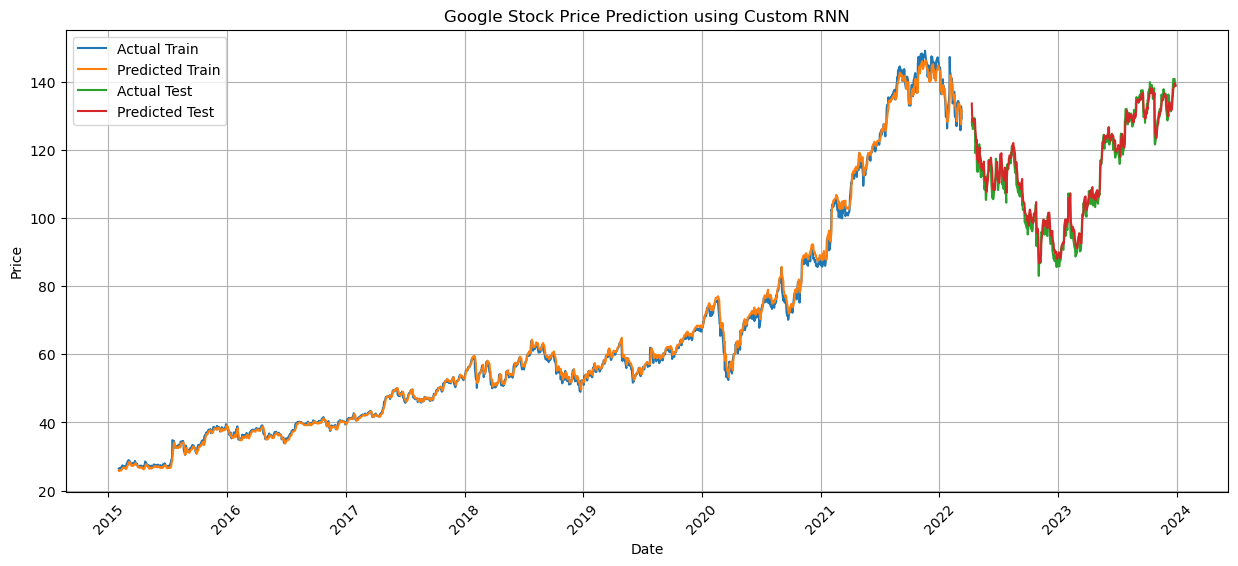

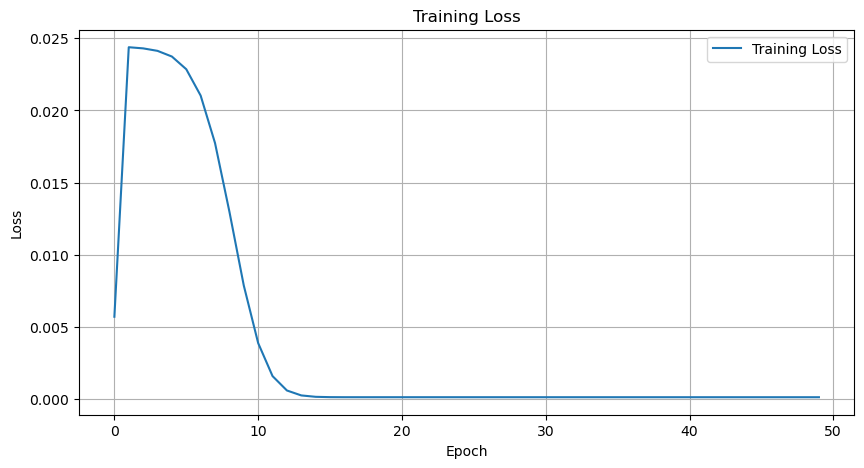

In [12]:
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.index[SEQ_LENGTH:train_size], y_train_inv, label='Actual Train')
plt.plot(df.index[SEQ_LENGTH:train_size], train_predict, label='Predicted Train')
test_start_idx = train_size + SEQ_LENGTH
plt.plot(df.index[test_start_idx:], y_test_inv, label='Actual Test')
plt.plot(df.index[test_start_idx:], test_predict, label='Predicted Test')
plt.title('Google Stock Price Prediction using Custom RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
